Chris finds that, within a given redshift bin, the average uncertainty in the log distance ratio is less than the standard deviation of the log distance ratios in both the data and the mocks, and that the mocks are significantly larger than the data.

I don't find this when I recreate the mocks and compare with v15 - do I see this with v13 and the v13 mocks?

In [15]:
import numpy as np

from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const

import matplotlib.pyplot as plt

import sys
sys.path.append('/global/u1/k/kadglass/DESI_SGA/TF/')
from help_functions import profile_histogram

In [16]:
LightSpeed = const.c.to('km/s').value

h = 1
cosmology = FlatLambdaCDM(H0=100*h, Om0=0.3151)

In [13]:
pvpath = '/global/cfs/cdirs/desi/science/td/pv/'

# Mock

In [3]:
mock_dir = pvpath + 'mocks/TF_mocks/fullmocks/v0.5.4/'

mock_name = 'TF_AbacusSummit_base_c000_ph000_r001_z0.11.fits'

mock = Table.read(mock_dir + mock_name)

In [11]:
mock.colnames

['RA',
 'DEC',
 'ZOBS',
 'ZCOS',
 'vx',
 'vy',
 'vz',
 'DWARF',
 'MAIN',
 'LOGVROT',
 'R_ABSMAG_SB26',
 'LOGDIST_TRUE',
 'LOGDIST',
 'LOGDIST_ERR',
 'Y1_COMP',
 'Y3_COMP']

# Data

In [5]:
data_dir = pvpath + 'tfgalaxies/Y1/'

data_name = 'DESI-DR1_TF_pv_cat_v13.fits'

data = Table.read(data_dir + data_name)

# Compare

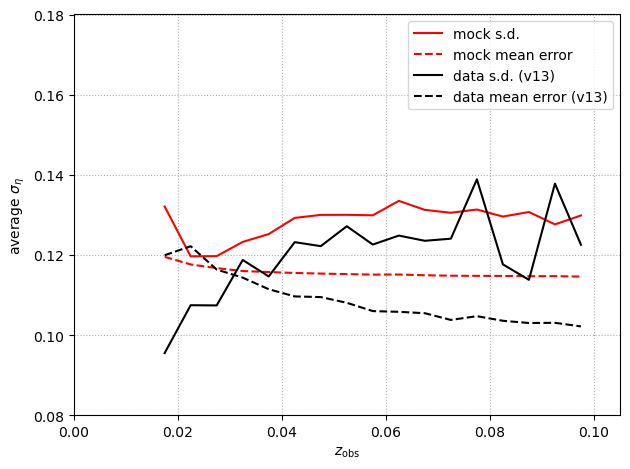

In [10]:
# In each redshift bin, compute the standard deviation of the log-distance ratios
# And compare this to the average value of the uncertainty in the log-distance ratio in each bin
# Do this for both mocks and data

plt.figure(tight_layout=True)

plt.grid(ls=':')

_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

# Mock standard deviation in each bin
_, eta_std,_ = profile_histogram(mock['ZOBS'][mock['MAIN']], 
                                 mock['LOGDIST'][mock['MAIN']], 
                                 _zbins, 
                                 stat='std')
plt.plot(zc, eta_std, 'r', label='mock s.d.')

# Mock average error
_, eta_err_avg,_ = profile_histogram(mock['ZOBS'][mock['MAIN']], 
                                     mock['LOGDIST_ERR'][mock['MAIN']], 
                                     _zbins)
plt.plot(zc, eta_err_avg, 'r--', label='mock mean error')

# Data standard deviation in each bin
_, data_eta_std,_ = profile_histogram(data['Z_DESI'][data['MAIN']], 
                                      data['LOGDIST'][data['MAIN']], 
                                      _zbins, 
                                      stat='std')
plt.plot(zc, data_eta_std, 'k', label='data s.d. (v13)')

# Data average error
_, data_eta_err_avg,_ = profile_histogram(data['Z_DESI'][data['MAIN']], 
                                          data['LOGDIST_ERR'][data['MAIN']], 
                                          _zbins)
plt.plot(zc, data_eta_err_avg, 'k--', label='data mean error (v13)')


plt.legend()

plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel(r'average $\sigma_\eta$')

plt.xlim(0,0.105)
plt.ylim(0.08, 0.18);

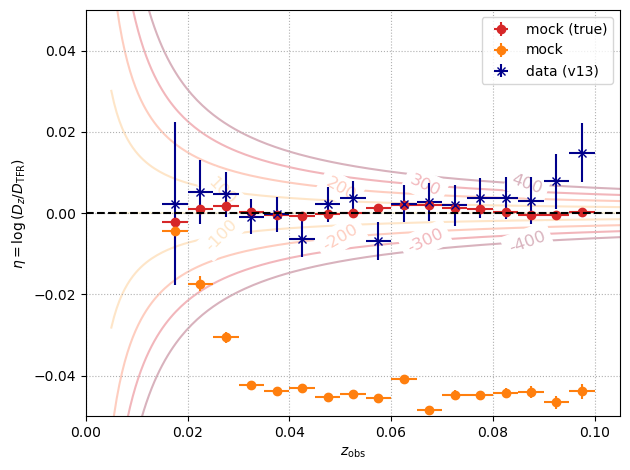

In [18]:
fig = plt.figure(tight_layout=True)

_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])


plt.grid(ls=':')

# True mock
_, eta_avg, eta_std = profile_histogram(mock['ZOBS'][mock['MAIN']], 
                                        mock['LOGDIST_TRUE'][mock['MAIN']], 
                                        _zbins)
plt.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:red', label='mock (true)')

# Mock
_, eta_avg, eta_std = profile_histogram(mock['ZOBS'][mock['MAIN']], 
                                        mock['LOGDIST'][mock['MAIN']], 
                                        _zbins, 
                                        weights=mock['LOGDIST_ERR'][mock['MAIN']]**-2, 
                                        weighted=True)
plt.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='mock')

# Data
_, data_eta_avg, data_eta_std = profile_histogram(data['Z_DESI'][data['MAIN']], 
                                                  data['LOGDIST'][data['MAIN']], 
                                                  _zbins, 
                                                  weights=data['LOGDIST_ERR'][data['MAIN']]**-2, 
                                                  weighted=True)
plt.errorbar(zc, data_eta_avg, xerr=dz, yerr=data_eta_std, fmt='x', color='darkblue', label='data (v13)')

#-------------------------------------------------------------------------------
# PV lines (code taken from Cullen)
#-------------------------------------------------------------------------------
velarray = np.arange(-400, 401, 100)
zarray = np.linspace(0.005, 0.11, 200)

dzarray = cosmology.comoving_distance(zarray).value
dharray = cosmology.comoving_distance(np.outer(1.0/(1.0 + velarray/LightSpeed), 
    								  (1.0 + zarray)) - 1.0).value
deltamarray = np.log10(dzarray/dharray)

rotation = [20.0, 25.0, 30.0, 45.0, 0.0, -45.0, -30.0, -25.0, -20.0]
labels = ["-400", "-300", "-200", "-100", "0", "100", "200", "300", "400"]
xcoord = np.array([26000.0, 20000.0, 15000.0, 8000.0, -1000.0, 8000.0, 15000.0, 20000.0, 26000.0])
coord = np.searchsorted(zarray, xcoord/LightSpeed)
ycoord = np.array([deltamarray[i,j] for i, j in enumerate(coord)])

colors = 0.8*np.fabs(velarray)/np.amax(np.fabs(velarray)) + 0.2

for v in range(len(velarray)):
    c = plt.cm.YlOrRd(colors[v])

    plt.plot(zarray, deltamarray[v,:], 
             color=c, 
             linestyle='-', 
             alpha=0.3, 
             zorder=0)

    if (v != 4):
        plt.text(xcoord[v]/LightSpeed, ycoord[v], 
                 labels[v], 
                 color=c, 
                 fontsize=12, 
                 rotation=rotation[v], 
                 ha="center", 
                 va="center", 
                 bbox=dict(boxstyle="square", ec="w", fc="w"), 
                 zorder=1, 
                 alpha=0.3)

# Line at eta = 0
plt.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)
#-------------------------------------------------------------------------------

plt.legend()

plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel(r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')

plt.xlim(0,0.105)
plt.ylim(-0.05, 0.05);

# fig.savefig('tfr_mock_eta.png', dpi=150);